In [63]:
from pathlib import Path
import regex as re

In [69]:
# take text line by line from source files
def read_text(path):
    with Path(path).open(encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line:
                yield line # yield keyword more memory and time efficient for line by line processing than returning full list of sentences all at once

In [70]:
# normalizing text - all lowercase letters, get rid of numbers and special symbols.
def normalize_text(text):
    return re.sub(r"[^\p{L}\s]", "", text.lower())

In [71]:
# process for cleaning one file
def preprocess_file(input_path, output_path):
    with open(output_path, "w", encoding="utf-8") as output:
        for i in read_text(input_path):
            clean = normalize_text(i)
            if clean:
                output.write(clean + "\n")

In [72]:
# process for cleaning a directory
def preprocess_dir(root_dir, output_root):
    root_dir = Path(root_dir)
    output_root = Path(output_root)
    for file in root_dir.rglob("*"):
        if file.is_file():
            rel_path = file.relative_to(root_dir) # extracts relative path
            output_file = output_root / rel_path # creates a new path for the output file
            output_file.parent.mkdir(parents = True, exist_ok = True) # creates any necessary parent directories if they dont already exist, as well as suppressing an error if the parents already exist
            preprocess_file(file, output_file) 

In [73]:
# call functions to clean source directories
preprocess_dir("SOURCE_romance", "CLEANED_romance")
preprocess_dir("SOURCE_germanic","CLEANED_germanic")

In [74]:
from pathlib import Path
from collections import Counter
import json

In [75]:
# create ngrams of length n, do not include ngrams with newline character
def char_ngrams(text, n):
    return [text[i:i+n] for i in range(len(text)-n+1) if '\n' not in text[i:i+n]]

In [76]:
def get_freq_vector(ngrams):
    counts = Counter(ngrams) # stores the count of ngrams as key-value pairs
    total = sum(counts.values()) # total number of ngrams
    return {k: v/total for k, v in counts.items()} # returns a dictionary with each unique ngram as the key and the frequency as the value

In [79]:
# creates language vectors 
def ngram_frequencies_by_language(root_dir, n = 3):
    lang_vectors = {} # create a dictionary to store the language vectors
    root = Path(root_dir)

    for lang_dir in root.iterdir(): # iterates through the root directory
        print(lang_dir) # print statement to track progress
        if lang_dir.is_dir():
            all_text = [] # make a list to store the text
            for file in lang_dir.rglob("*"): # goes through all files inside the directory
                # appends the text in the file to the all_text list if the file is valid
                if file.is_file():
                    all_text.append(file.read_text(encoding="utf-8"))
            text = "\n".join(all_text) # joins all the text together with newline characters
            ngrams = char_ngrams(text, n) # creates ngrams
            lang_vectors[lang_dir.name] = get_freq_vector(ngrams) # returns dictionary of language vectors.

    return lang_vectors # return our language vectors

In [ ]:
# calling functions to actually create language vectors
germanic_vectors = ngram_frequencies_by_language("CLEANED_germanic", 3)
romance_vectors = ngram_frequencies_by_language("CLEANED_romance", 3)
vectors = germanic_vectors # create a container for the vectors
vectors.update(romance_vectors) # add the romance vectors to the container.

with open("language_ngram_vectors.json", "w", encoding="utf-8") as file: # write all the vectors to a json file
    json.dump(vectors, file, ensure_ascii=False, indent=2)

CLEANED_germanic\Dutch
CLEANED_germanic\English
CLEANED_germanic\German
CLEANED_germanic\Swedish
CLEANED_romance\French
CLEANED_romance\Italian
CLEANED_romance\Portuguese
CLEANED_romance\Romanian
CLEANED_romance\Spanish


In [81]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [ ]:
# load language vectors from desired file
with open("language_ngram_vectors.json", "r", encoding="utf-8") as f:
    lang_vectors = json.load(f)

# need to create a list of all unique n_grams that appear in all of our texts
all_ngrams_set = set() # start with a set to avoid duplicates

for lang_vector in lang_vectors.values(): # loop over the language vectors
    for n_gram in lang_vector: # loop over the ngrams in the language vector
        all_ngrams_set.add(n_gram) # add the ngram to the set

all_ngrams = sorted(all_ngrams_set) # convert to a sorted list (sorted for reproducibility, since sets are unordered)
names = list(lang_vectors.keys()) # list stores the names of the languages we are working with

# creates a matrix where each row corresponds to a language, each column corresponds to an ngram, and each entry is defined as the frequency of that ngram within the languages text
matrix = np.array([
    [lang_vectors[language].get(n_gram, 0.0) for n_gram in all_ngrams]
    for language in names
], dtype=float)

In [115]:
# Pairwise cosine distance
# cosine similarity = dot(a,b)/(||a||*||b||)
dot_products = matrix @ matrix.T # find dot products between each language
norms = norm(matrix, axis=1) # find norms of each vector
cosine_similarity = dot_products / np.outer(norms, norms) # compute cosine similarity
distance = np.clip(1.0 - cosine_similarity, 0.0, None)   # computes symmetric distance matrix

In [ ]:
# UMAP embedding
reducer = umap.UMAP(metric="cosine", n_components=2, random_state=42, n_neighbors=3, n_jobs=1) # create a reducer using the cosine similarity metric
embedding = reducer.fit_transform(distance) # make an embedding from the reducer using our distance matrix 

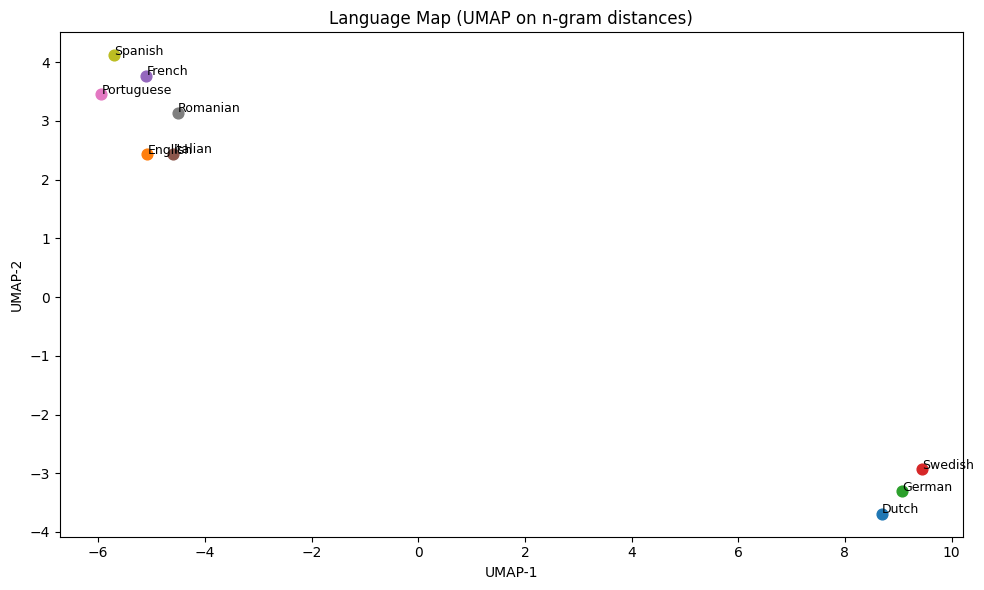

In [156]:
# plotting
plt.figure(figsize=(10, 6))
for i, lang in enumerate(names):
    x, y = embedding[i]
    plt.scatter(x, y, s=60)
    plt.text(x + 0.01, y + 0.01, lang, fontsize=9)
plt.title("Language Map (UMAP on n-gram distances)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [118]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

In [119]:
with open("language_ngram_vectors.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data).fillna(0).T # make dataframe with ngram frequency per language - fill NA entries with 0, and take transpose.
languages = df.index.tolist() # get list of language names
label_map = {lang: i for i, lang in enumerate(languages)} # associate each language with a number

features = torch.tensor(df.values, dtype=torch.float32) # frequency values for each language
targets = torch.tensor([label_map[lang] for lang in languages], dtype=torch.int64) # numbers for each language

dataset = TensorDataset(features, targets) # convert data to a torch tensor
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) # create an iterable to train the model on the data

In [ ]:
# define a simple neural network (multi layer perceptron)
class MLPClassifier(nn.Module):
    # our model will consist of a linear layer, a ReLU activation function to introduce non linearity, and another linear layer to map our hidden features to outputs
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    # forward pass (passes the input tensor through the layers in sequence)
    def forward(self, x):
        return self.model(x)

In [135]:
# training loop
def train(model, optimizer, dataloader, epochs):
    # create an accuracy metric to track classification performance
    accuracy = Accuracy(task = "multiclass", num_classes=len(languages))
    # create variables to help compute AVERAGE accuracy over all epochs
    total_acc = 0
    count = 0

    for epoch in range(epochs): # loop over the dataset
        for x, target in dataloader: # iterate over batches from dataloader
            pred = model(x) # compute model predictions
            loss = cross_entropy(pred, target) # compute cross entropy loss between the models predictions and the expected result
            loss.backward() # back propagation - compute gradients
            optimizer.step() # update model parameters
            optimizer.zero_grad() # reset the gradients
            total_acc += accuracy(pred, target).item() # compute accuracy for the previous epoch
            count += 1 # increment the count of epochs completed
        avg_acc = total_acc / count # update the average accuracy
        if epoch % 10 == 0: # prints progress updates for training every 10 epochs 
            print(f"Epoch {epoch}: loss={loss.item():.3f}, acc={avg_acc:.3f}")

In [134]:
input_dim = features.shape[1] # get dimension of input 
hidden_dim = 128 # number of neurons in the hidden layer 
output_dim = len(languages) # an output neuron for each language we need to classify

model = MLPClassifier(input_dim, hidden_dim, output_dim) # create an instance of our neural network!
optimizer = Adam(model.parameters(), lr=0.01) # initialize an optimizer!

train(model, optimizer, dataloader, epochs=200) # call training loop

Epoch 0: loss=2.238, acc=0.083
Epoch 10: loss=1.874, acc=0.508
Epoch 20: loss=0.971, acc=0.639
Epoch 30: loss=0.315, acc=0.715
Epoch 40: loss=0.476, acc=0.776
Epoch 50: loss=0.419, acc=0.820
Epoch 60: loss=0.041, acc=0.850
Epoch 70: loss=0.105, acc=0.871
Epoch 80: loss=0.088, acc=0.887
Epoch 90: loss=0.036, acc=0.899
Epoch 100: loss=0.025, acc=0.909
Epoch 110: loss=0.010, acc=0.917
Epoch 120: loss=0.006, acc=0.924
Epoch 130: loss=0.017, acc=0.930
Epoch 140: loss=0.005, acc=0.935
Epoch 150: loss=0.014, acc=0.939
Epoch 160: loss=0.005, acc=0.943
Epoch 170: loss=0.003, acc=0.946
Epoch 180: loss=0.005, acc=0.949
Epoch 190: loss=0.006, acc=0.952


In [138]:
# function to take inputted text and return a small dictionary containing the extracted frequencies of the ngrams
def mini_ngram_frequencies(text, n=3): # uses n=3 as default, but if we have trained the classifier on 4-grams, we should specify n=4 so we can make valid comparisons
    text = text.lower()
    ngrams = [text[i:i+n] for i in range(len(text) - 2)]
    counts = Counter(ngrams)
    total = sum(counts.values())
    return {trigram: count / total for trigram, count in counts.items()} if total > 0 else {}

In [ ]:
# creates a tensor with the frequencies of the inputted text
def text_to_tensor(text, columns):
    freqs = mini_ngram_frequencies(text) # get frequencies of ngrams present in the text
    vec = np.array([freqs.get(ngram, 0.0) for ngram in columns], dtype=np.float32) # create an array of the ngrams frequencies within the text
    return torch.tensor(vec).unsqueeze(0)  # shape (1, num_features)

In [ ]:
# predict the language given the frequencies from the inputted texts ngrams
def predict_language(text, model, columns, label_map):
    model.eval()
    x = text_to_tensor(text, columns)
    with torch.no_grad():
        output = model(x) # gets output from classifier
        pred_index = torch.argmax(output, dim=1).item() # finds the index of the node with the highest output value
    index_to_lang = {v: k for k, v in label_map.items()} # flips the keys and values in the label map
    return index_to_lang[pred_index] # gets the name of the language at the index of the highest output from the classifier

In [38]:
while(True):
    text = input("Input some text, or type 'stop' to stop: ")
    if text.upper() == "STOP":
        break
    pred = predict_language(text, model, df.columns, label_map)
    print(f"INPUTTED TEXT: {text} \n   PREDICTED LANGUAGE: {pred}\n")

INPUTTED TEXT: what language is this 
   PREDICTED LANGUAGE: English

INPUTTED TEXT: welche Sprache ist das? 
   PREDICTED LANGUAGE: German

INPUTTED TEXT: ce limba este asta 
   PREDICTED LANGUAGE: Romanian

INPUTTED TEXT: ¿Qué idioma es este? 
   PREDICTED LANGUAGE: Spanish

INPUTTED TEXT: que idioma é esse 
   PREDICTED LANGUAGE: Portuguese

INPUTTED TEXT: che lingua è questa? 
   PREDICTED LANGUAGE: Italian

INPUTTED TEXT: vilket språk är detta 
   PREDICTED LANGUAGE: Swedish

INPUTTED TEXT: welke taal is dit 
   PREDICTED LANGUAGE: Dutch

INPUTTED TEXT: c'est quelle langue 
   PREDICTED LANGUAGE: French

